<a href="https://colab.research.google.com/github/mojivalipour/nnscratch/blob/master/CS486-686_A2Q2ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Design and Programming by Lead TA: Mojtaba Valipour @ Data Analytics Lab - UWaterloo.ca
# COURSE: CS 486/686 - Artificial Intelligence - University of Waterloo - Spring 2020 - Alice Gao
# Please let me know if you find any bugs in the code: m5valipo@uwaterloo.ca
# The code will be available at https://github.com/mojivalipour/nnscratch
# Version: 0.9.0

In [2]:
# Implement a neural network from scratch
''' Sources:
- http://neuralnetworksanddeeplearning.com/chap2.html
'''
print('Life is easy, you just need to do your best to find your place!')

Life is easy, you just need to do your best to find your place!


In [0]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn import datasets
from sklearn.manifold import TSNE # visualization for data with more than two features
from google.colab import files # if it is colab
from os import path
import pandas as pd
import csv
import copy
import random

In [0]:
# Helper functions
def fixSeed(seed=1010):
    np.random.seed(seed)
    random.seed(seed)

In [0]:
# The hyper-parameters for the neural network

nSamples = None # use None if you want to use full sample size
dataset = '2moons' # 2moons/circles/frogsSmall/frogs
noise = 0.05 # Noise in artificial datasets
visNumSamples = 500 # number of samples to visualize

# for regression, we use mean squared error. 
# for classification, we use cross entropy.
# for now only mse is supported!
lossFunction = 'mse' 

gdMethod = 'minibatch' # batch/minibatch/stochastic = gradient descent method
batchSize = 64 # only for minibatch gradient descent
numEpochs = 200 # number of epochs
learningRate = [0.5,0.05,0.005] # learning rates

# for now only relu and sigmoid is supported
lastActivationFunc = 'sigmoid' # relu/sigmoid/softmax 
# last layer activation function, this one is important 
# because we need to use it for classification later

crossValidationFlag = True # if you like to run cross validation, set this flag to True
kFold = 3 # k-fold cross validation, at least need to be 2

seed = 6565 # Do not change the seed for Assignment

In [0]:
fixSeed(seed=seed) # fix the seed of random generator to make sure comparision is possible 

In [7]:
# Some Useful Notes for those students who are interested to know more:
'''
- Neural networks are prone to overfitting.  Increasing the number of parameters 
  could lead to models that have complexity bigger than data. 
- Regularization, Normalization and Dropout are popular solutions to overfitting!
- In a neural network, we usually use the softmax function as last layer 
  activation for multi-class classification and sigmoid for single class 
  classification.
- For regression problems, we usually use Relu as last layer activation function 
  and MSE as the loss function that we want to minimize.
- Cross-entropy is the most useful loss function for multi-class classification.
- Sometimes we need to use multiple neurons in the output layer, which means 
  that we consider a neuron for each class.  In this case, we need to use 
  one-hot vectors to encode the labels. 
- Weight initialization is important! Gradient descent is not robust to 
  weight initialization! Xavier initialization is the most popular method 
  to initialize weights in neural networks.
'''
print('### MORE INFO HERE ###')

### MORE INFO HERE ###


#INFO: N (Number of Samples): 1000, D (Number of Features): 2, C (Number of Classes): 2


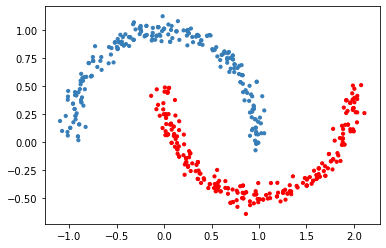

In [8]:
# Load data
colorBox = ['#377eb8','#FA0000','#344AA7', '#1EFA39','#00FBFF','#C500FF','#000000','#FFB600']

if dataset == '2moons':
  nSamples = 1000 if nSamples is None else nSamples
  X,y = datasets.make_moons(n_samples=nSamples, noise=noise, random_state=seed)
  numSamples, numFeatures, numClasses = X.shape[0], X.shape[1], 2

  # shuffle X,y 
  idxList = list(range(nSamples))
  random.shuffle(idxList) # inplace
  X, y = X[idxList,:], y[idxList]

elif dataset == 'circles':
  nSamples = 1000 if nSamples is None else nSamples
  X,y = datasets.make_circles(n_samples=nSamples, factor=.5, noise=noise, random_state=seed)
  numSamples, numFeatures, numClasses = X.shape[0], X.shape[1], 2

elif dataset == 'frogsSmall' or dataset == 'frogs': 

  if dataset == 'frogs':
    # original dataset
    name = 'Frogs_MFCCs.csv'
  else:
    # a small subset of frogs original dataset, same as A2Q1
    name = 'frogs-small.csv'

  # check if we already have the file in the directory
  if not path.isfile(name):
    # otherwise ask user to upload it
    print("Please upload {} in the current directory using choose files ...".format(name))
    # only in case of google colab
    uploaded = files.upload() # choose frogs-small.csv
    del uploaded

  # just load the csv file
  X = pd.read_csv(name, sep=',') 
  #np.genfromtxt(name, delimiter=',', names=True, dtype=None)
  #X = pd.get_dummies(X, columns=["Family"]) 
  # convert categorical data to one-hot encoded one, 
  # only useful for cross-entropy not mse
  X["Family"] = X["Family"].astype('category')
  X["FamilyCat"] = X["Family"].cat.codes # added to the last column
  X, y = X.iloc[:,0:22].to_numpy(), X.iloc[:,-1].to_numpy()
  
  nSamples = X.shape[0] if nSamples is None else nSamples
  X, y = X[:nSamples,:], y[:nSamples] # filter number of samples
  
  numSamples, numFeatures, numClasses = X.shape[0], X.shape[1], len(np.unique(y))

print('#INFO: N (Number of Samples): {}, D (Number of Features): {}, C (Number of Classes): {}'.format(numSamples, numFeatures, numClasses))
plt.figure()

# if y min is not zero, make it zero
y = y - y.min()
assert y.min() == 0

# sample required sample for visualization
indices = list(range(numSamples))
selectedIndices = np.random.choice(indices, visNumSamples)
colors = [colorBox[y[idx]] for idx in selectedIndices]
if numFeatures == 2:
  XR = X[selectedIndices, :]
else: 
  # use tsne to reduce dimensionality for visualization
  XR = TSNE(n_components=2).fit_transform(X[selectedIndices,:])
plt.scatter(XR[:, 0], XR[:, 1], s=10, color=colors)

if len(y.shape) < 2:
  y = np.expand_dims(y,-1) # shape of y should be N x 1

In [0]:
# Define the network structure

# # 2-Layer Network
# config = {
#     # Layer Name: [Number of Nodes (in and out), Bias, Activation Function]
#     'Hidden Layer 0':  [[numFeatures, 30], True, 'relu'], # w1
#     'Fully Connected': [[30, 1],  True, lastActivationFunc] # w2
# }

# overfit network
config = {
    # Layer Name: [Number of Nodes (in and out), Bias, Activation Function]
    'Hidden Layer 0':  [[numFeatures, 1000], True, 'sigmoid'], # w1
    'Fully Connected': [[1000, 1],  True, lastActivationFunc] # w2
}

# 3-Layer Network
# config = {
#     # Layer Name: [Number of Nodes (in and out), Bias, Activation Function]
#     'Hidden Layer 0':  [[numFeatures, 3], True, 'sigmoid'], # w1
#     'Hidden Layer 1':  [[3, 5], True, 'sigmoid'], # w2
#     'Fully Connected': [[5, 1],  True, lastActivationFunc] # w2
# }

# 4-layer Network
# config = {
#     # Layer Name: [Number of Nodes (in and out), Bias, Activation Function]
#     'Hidden Layer 0':  [[numFeatures, 100], True, 'relu'], # w1
#     'Hidden Layer 1':  [[100, 50], True, 'relu'], # w2
#     'Hidden Layer 2':  [[50, 5], True, 'relu'], # w3
#     'Fully Connected': [[5, 1],  True, lastActivationFunc] # w4
# }

In [0]:
# Fully Connected Neural Network Class
class neuralNetwork():
  
    # initializing network
    def __init__(self, config=None, numClass=2, learningRate=0.005, 
                 numEpochs=10, batchSize= 64, lossFunction='crossEntropy'):
        self.config = config
        self.configKeyList = list(self.config.keys())
        self.lossFunction = lossFunction
        self.numLayers = len(self.config)
        self.layers = {} 
        self.layerShapes = {}
        self.learningRate = learningRate
        self.numEpochs = numEpochs
        self.loss = []
        self.lossT = []
        self.acc = []
        self.accT = []
        self.batchSize = batchSize
        self.numClass = numClass
        
        self.initWeights()
        
    # random init
    def initWeights(self):
        self.loss = []
        self.lossT = []
        self.acc = []
        self.accT = []
        if self.config != None:
            for key in config:
                # w is parameters, b is bias, a is activation function
                self.layers[key] = {'W':np.random.randn(self.config[key][0][0],self.config[key][0][1])/np.sqrt(self.config[key][0][1]), 
                                    'b':np.random.randn(self.config[key][0][1],) if self.config[key][1]==True else [], 'a':self.config[key][2]}
                # keep track of shape only for better understanding
                self.layerShapes[key] = {'IS':self.config[key][0][0],'OS':self.config[key][0][1],
                                         'NP':np.prod(self.layers[key]['W'].shape)+len(self.layers[key]['b'])}
        else:
            raise '#Err: Make sure you set a configuration correctly!'
    
    # activation functions
    def relu(self, X):
        return np.maximum(0, X)
    def sigmoid(self, X):
        #TODO: fix the overflow problem in Numpy exp function
        return 1./(1. + np.exp(-X))
    def softmax(self, X):
        expVal = np.exp(X - np.max(X)) # np.max(X) is for numerical stability
        return expVal / expVal.sum(axis=0, keepdims=True)
       
    def activationFunc(self, X, type='sigmoid'):
        if type == 'sigmoid':
            return self.sigmoid(X)
        elif type == 'relu':
            return self.relu(X)
        elif type == 'softmax':
            return self.softmax(X)
        elif type == 'None':
            return X # do nothing
        else:
            raise '#Err: Not implemented activation function!'
            
    # objective/loss/cost functions
    def mse(self, y, yPred): # mean square error
        return np.mean(np.power(y-yPred,2))

    def crossEntropy(self, y, yPred):
        return -np.mean(y * np.log(yPred + 1e-8))

    def lossFunc(self, y, yPred, type='mse'):
        if type == 'crossEntropy':
            return self.crossEntropy(y, yPred) 
            # consider yPred should be equal to yPred = softmax(Logits), 
            # this means for the last layer we need to use softmax 
            # as the activation function
        elif type == 'mse':
            return self.mse(y, yPred)
        else:
            raise '#Err: Not implemented objective function!'
    
    # back-propagation learning
    # forward pass
    def forward(self, X):
        # apply a(W.T x X + b) for each layer
        for key in config:
            #print(X.shape, self.layers[key]['W'].shape)

            # save input of each layer for backward pass
            self.layers[key]['i'] = X 
            
            z = np.dot(X, self.layers[key]['W']) 
            z = z + self.layers[key]['b'] if len(self.layers[key]['b'])!=0 else z

            # save middle calculation for backward pass
            self.layers[key]['z'] = z 
            X = self.activationFunc(z, type=self.layers[key]['a'])

            # save middle calculation for backward pass
            self.layers[key]['o'] = X 

        return X # yPred

    # backward pass
    def backward(self, y, yPred):

        # derivative of sigmoid
        def sigmoidPrime(x): 
            return self.sigmoid(x) * (1-self.sigmoid(x))

        # derivative of relu
        def reluPrime(x):
            return np.where(x <= 0, 0, 1)

        def softmaxPrime(x):
            # x should be one-hot encoded for different classes
            # and for each class we need to calculate the derivative
            raise '#Err: Softmax is not supported yet!'
        def identity(x):
          return x
        
        # compare gradient with numerical gradient
        # def sanityCheck(w, loss, eps=1e-5):      

        #TODO: It's not necessary to use double for, 
        # it is possible to implement faster and more efficient version
        # for each parameter (weights and bias) in each layer
        for idx, key in enumerate(config):
          #print(key)
          # calculate derivatives
          if self.layers[key]['a'] == 'sigmoid':
              fPrime = sigmoidPrime  
          elif self.layers[key]['a'] == 'relu':
              fPrime = reluPrime  
          elif self.layers[key]['a'] == 'softmax':
              fPrime = softmaxPrime
          else: # None 
              fPrime = identity
          
          #deWRTdyPred = -(y-yPred) if self.lossFunction == 'mse' else 1 # de/dyPred
          if self.lossFunction == 'mse':
            deWRTdyPred = -(y-yPred)
          elif self.lossFunction == 'crossEntropy':
            raise '#Err: Cross-Entropy is not supported yet!'
          else:
            deWRTdyPred = 1
          #print('de/dy')

          # dyPred/dyPredBeforeActivation # in case of sigmoid g(x) x (1-g(x))
          dyPredWRTdyPredPre = fPrime(self.layers[self.configKeyList[-1]]['o']) 
          #print('dy/dz')

          # element wise multiplication/ hadamard product
          delta = np.multiply(deWRTdyPred, dyPredWRTdyPredPre) 
          for idxW in range(len(config),idx,-1): # reverse
            if idxW-1 == idx:
              # calculating the derivative for the last one is different 
              # because it is respected to that specific weight
              #print('\nWeights of layer',idx)
              deltaB = delta
              dxWRTdW = self.layers[key]['i'].T # dxWRTdW
              delta = np.dot(dxWRTdW,delta)
              #print('dz/dw')
            else:
              # this loop is depended to the number of layers in the configuration
              #print('\nWeights of layer',idxW-1)
              # the weights of current layer
              # how fast the cost is changing as a function of the output activation
              dxWRTdh = self.layers[self.configKeyList[idxW-1]]['W'].T # dxPreWRTdx-1
              #print('dz/da')
              #print('output of layer',idxW-1-1)
              # the output of previous layer
              # how fast the activation function is changing 
              dhWRTdhPre = fPrime(self.layers[self.configKeyList[idxW-1-1]]['o']) # dx-1WRTdx-1Pre
              #print('da/dz')
              delta = np.dot(delta, dxWRTdh) * dhWRTdhPre
              
          # sanity check: Numerical Gradient Checking
          # f'(x) = lim (f(x+deltax)-f(x))/deltax when deltax -> 0
          
          # update parameters
          # W = W - Gamma * dL/dW
          self.layers[key]['djWRTdw'] = delta
          self.layers[key]['W'] = self.layers[key]['W'] \
                                - self.learningRate/y.shape[0] * delta
          # b = b - Gamma * dL/db
          self.layers[key]['djWRTdb'] = deltaB
          if len(self.layers[key]['b'])!=0:
            self.layers[key]['b'] = self.layers[key]['b'] \
                    - self.learningRate/y.shape[0] * np.sum(deltaB, axis=0)
    
    # Utility Functions
    def summary(self, space=20):
        print('{: <{}} | {: <{}} | {: <{}} | {: <{}}'.format("Layer Name", space, 
                                                      "Input Shape", space, 
                                                      "Output Shape", space, 
                                                      "Number of Parameters",space))
        for key in config:
            print('{: <{}} | {: <{}} | {: <{}} | {: <{}}'.format(key, space,
                                        self.layerShapes[key]['IS'], space, 
                                        self.layerShapes[key]['OS'], space,
                                        self.layerShapes[key]['NP'], space))
    
    def fit(self, X, y, XT=None, yT=None, method='minibatch', batchSize=None, numEpochs=None, 
            learningRate=None, initialState=None):
      if numEpochs is None: # overwrite
        numEpochs = self.numEpochs

      if learningRate is not None:
        self.learningRate = learningRate

      if batchSize is not None:
        self.batchSize = batchSize

      # if initialState is not None:
      #   # use the given initial parameters (weights and bias)
      #   self.layers = initialState

      if method == 'batch':
        # same as gradient descent in class to make it easier for you, 
        # easy to get stuck in local optima
        # batch gradient descent, apply the backpropagation on the whole data once
        pBar = tqdm(range(numEpochs))
        for edx in pBar:
          yPred = self.forward(X)
          loss = self.lossFunc(y, yPred, type=self.lossFunction)
          #pBar.set_description('loss={0:.5f}'.format(loss))
          self.backward(y, yPred)
          self.loss.append(loss)
          acc = self.accuracy(y, yPred)
          self.acc.append(acc)

          if XT is not None:
            yPred = self.forward(XT)
            loss = self.lossFunc(yT, yPred, type=self.lossFunction)
            self.lossT.append(loss)
            acc = self.accuracy(yT, yPred)
            self.accT.append(acc)

      elif method == 'stochastic': 
        # stochastic gradient descent, it's highly unstable
        # calculate gradient for each sample
        pBar = tqdm(range(numEpochs))
        for edx in pBar:
          #lossAvg = 0
          #counter = 0
          for x_, y_ in zip(X,y):
            if len(x_.shape) < 2:
              x_ = np.expand_dims(x_,0)
            if len(y_.shape) < 2:
              y_ = np.expand_dims(y_,0)

            yPred = self.forward(x_)
            loss = self.lossFunc(y_, yPred, type=self.lossFunction)
            self.backward(y_, yPred)
            #lossAvg += loss
            #counter += 1

          #lossAvg /= counter
          #pBar.set_description('loss={0:.5f}'.format(loss))
          #self.loss.append(lossAvg)
          
          yPred = self.forward(X)
          loss = self.lossFunc(Y, yPred, type=self.lossFunction)
          self.loss.append(loss)
          acc = self.accuracy(y, yPred)
          self.acc.append(acc)

          if XT is not None:
            yPred = self.forward(XT)
            loss = self.lossFunc(yT, yPred, type=self.lossFunction)
            self.lossT.append(loss)
            acc = self.accuracy(yT, yPred)
            self.accT.append(acc)

      elif method == 'minibatch':
        # same as batched gradient descent in class to make it easier for you
        pBar = tqdm(range(numEpochs))
        for edx in pBar:
          #lossAvg = 0
          #counter = 1
          for idx in range(0, X.shape[0], self.batchSize):
            start = idx
            end = start + self.batchSize 
            end = end if end < X.shape[0] else X.shape[0]
            
            #TODO: Support variable batchsize
            if end-start != self.batchSize:
              continue
            
            x_, y_ = X[start:end, :], y[start:end, :]
            yPred = self.forward(x_)
            loss = self.lossFunc(y_, yPred, type=self.lossFunction)
            self.backward(y_, yPred)
            #lossAvg += loss
            #counter += 1
          #lossAvg /= counter
          #pBar.set_description('loss={0:.5f}'.format(loss))
          #self.loss.append(lossAvg)
          
          yPred,yPredOrig = self.predict(X)
          loss = self.lossFunc(y, yPredOrig, type=self.lossFunction)
          self.loss.append(loss)
          acc = self.accuracy(y, yPred)
          self.acc.append(acc)

          if XT is not None:
            yPred, yPredOrig = self.predict(XT)
            loss = self.lossFunc(yT, yPredOrig, type=self.lossFunction)
            self.lossT.append(loss)
            acc = self.accuracy(yT, yPred)
            self.accT.append(acc)

      else:
        raise '#Err: {} Gradient Descent Method is Not implemented!'.format(method)
    
    def predict(self, X):

        yPred = self.forward(X)
        yPredOrigin = copy.deepcopy(yPred)

        # last layer activation function, class prediction should be single 
        # and the output is between zero and one
        if self.config[self.configKeyList[-1]][-1] == 'sigmoid': 
          yPred[yPred < 0.5] = 0
          yPred[yPred >= 0.5] = 1

        # multi-class problem
        elif self.config[self.configKeyList[-1]][-1] == 'softmax': 
          raise '#Err: Prediction is not supported for softmax yet!'

        # single/multi class problem, single node and it can be anything greater than 0
        elif self.config[self.configKeyList[-1]][-1] == 'relu': 
          maxRange = self.numClass
          interval = 1
          for idx in range(0, maxRange, interval):
            if idx+1 == self.numClass:
              iVal = idx - 0.5
              yPred[yPred >= iVal] = idx
            else:
              iVal = idx + 0.5
              yPred[yPred < iVal] = idx
        return yPred, yPredOrigin
    
    def error(self, y, yPred):
        #np.sum(np.power(y-yPred,2))/y.shape[0]
        return self.lossFunc(y, yPred, type=self.lossFunction) 
        
    def accuracy(self, y, yPred):
        return 100*np.sum(y==yPred)/y.shape[0]

    def plotLoss(self, loss=None, ax=None):
      if loss is None:
        loss = self.loss

      if ax is None:
        plt.plot(loss)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss Per Epoch")
        plt.show()
      else:
        ax.plot(loss)
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.set_title("Loss Per Epoch")

    def crossValidationIndices(self, index, k=5):
      # index is a list of indexes

      cvList = []
      for idx in range(k): # iterate over k-folds
        interval = int(len(index)/k)
        start = idx * interval
        end = start + interval
        testIndexes = list(range(start,end))
        trainIndexes = list(range(0,start)) +  list(range(end,len(index)))

        cvList.append((trainIndexes, testIndexes))

      return cvList


Layer Name           | Input Shape          | Output Shape         | Number of Parameters
Hidden Layer 0       | 2                    | 1000                 | 3000                
Fully Connected      | 1000                 | 1                    | 1001                
#INFO: Mean squared error is 0.129
#INFO: Train Accuracy is 87.1



Layer Name           | Input Shape          | Output Shape         | Number of Parameters
Hidden Layer 0       | 2                    | 1000                 | 3000                
Fully Connected      | 1000                 | 1                    | 1001                
#INFO: Mean squared error is 0.108
#INFO: Train Accuracy is 89.2



Layer Name           | Input Shape          | Output Shape         | Number of Parameters
Hidden Layer 0       | 2                    | 1000                 | 3000                
Fully Connected      | 1000                 | 1                    | 1001                
#INFO: Mean squared error is 0.11
#INFO: Train Accuracy is 89.0


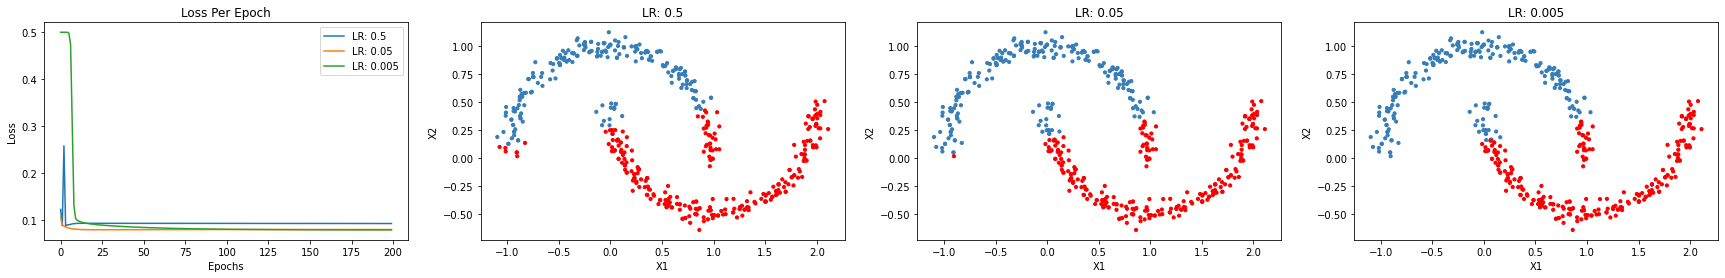

In [11]:
if crossValidationFlag:
  if len(learningRate) == 1:
    fig, ax = plt.subplots(3,len(learningRate),figsize=(8,15))
  else:
    fig, ax = plt.subplots(3,len(learningRate),figsize=(30,3*(len(learningRate)+2)))
else:
  fig, ax = plt.subplots(1,1+len(learningRate),figsize=(30,1+len(learningRate)))

for ldx, lr in enumerate(learningRate):
  nn = neuralNetwork(config=config, numClass=numClasses, numEpochs=numEpochs, 
                   learningRate=lr, lossFunction=lossFunction)
  # Initialize the network and the weights
  nn.initWeights()

  if crossValidationFlag:
    indexes = list(range(X.shape[0]))
    cvIndices = nn.crossValidationIndices(indexes, k=kFold)

    accList = []
    accTList = []
    lossList = []
    lossTList = []
    for k in range(kFold):
      nn.initWeights()
      XTrain, yTrain = X[cvIndices[k][0],:], y[cvIndices[k][0],:]
      XTest, yTest = X[cvIndices[k][1],:], y[cvIndices[k][1],:]
      # Train the network
      nn.fit(XTrain, yTrain, XTest, yTest, method=gdMethod, batchSize=batchSize, 
                  numEpochs=numEpochs, learningRate=lr)
      accList.append(nn.acc)
      accTList.append(nn.accT)
      lossList.append(nn.loss)
      lossTList.append(nn.lossT)

    acc = np.mean(accList, axis=0)
    accT = np.mean(accTList, axis=0)
    loss = np.mean(lossList, axis=0)
    lossT = np.mean(lossTList, axis=0)
      
    # print the network structure
    nn.summary()
    yPred, yPredOrig = nn.predict(X)
    print('#INFO: Mean squared error is {}'.format(nn.error(y,yPred)))

    colors = [colorBox[int(yPred[idx])] for idx in selectedIndices]
    if len(learningRate) == 1:
        ax[2].scatter(XR[:, 0], XR[:, 1], s=10, color=colors)
        ax[2].set_xlabel("X1")
        ax[2].set_ylabel("X2")
        ax[2].set_title("Data, LR: {}".format(lr))

        ax[0].plot(acc)
        ax[0].plot(accT)
        ax[0].legend(['Train','Test'])
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Accuracy")
        ax[0].set_title("Accuracy Per Epoch"+", LR: {}".format(lr))

        ax[1].plot(loss)
        ax[1].plot(lossT)
        ax[1].legend(['Train','Test'])
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Loss")
        ax[1].set_title("Loss Per Epoch"+", LR: {}".format(lr)) 
    else:
        ax[2,ldx].scatter(XR[:, 0], XR[:, 1], s=10, color=colors)
        ax[2,ldx].set_xlabel("X1")
        ax[2,ldx].set_ylabel("X2")
        ax[2,ldx].set_title("Data, LR: {}".format(lr))

        ax[0,ldx].plot(acc)
        ax[0,ldx].plot(accT)
        ax[0,ldx].legend(['Train','Test'])
        ax[0,ldx].set_xlabel("Epochs")
        ax[0,ldx].set_ylabel("Accuracy")
        ax[0,ldx].set_title("Accuracy Per Epoch"+", LR: {}".format(lr))

        ax[1,ldx].plot(loss)
        ax[1,ldx].plot(lossT)
        ax[1,ldx].legend(['Train','Test'])
        ax[1,ldx].set_xlabel("Epochs")
        ax[1,ldx].set_ylabel("Loss")
        ax[1,ldx].set_title("Loss Per Epoch"+", LR: {}".format(lr))
  else:
    # Perform a single run for visualization.
    nn.fit(X, y, method=gdMethod, batchSize=batchSize, numEpochs=numEpochs, 
        learningRate=lr)
    # print the network structure
    nn.summary()
    yPred, yPredOrig = nn.predict(X)
    print('#INFO: Mean squared error is {}'.format(nn.error(y,yPred)))
    
    colors = [colorBox[int(yPred[idx])] for idx in selectedIndices]
    ax[ldx+1].scatter(XR[:, 0], XR[:, 1], s=10, color=colors)
    ax[ldx+1].set_xlabel("X1")
    ax[ldx+1].set_ylabel("X2")
    ax[ldx+1].set_title("LR: {}".format(lr))

    # Plot the mean squared error with respect to the nu
    nn.plotLoss(ax=ax[0])

    # train accuracy
    acc = nn.accuracy(y.squeeze(-1),yPred.squeeze(-1)) 
    print('#INFO: Train Accuracy is {}'.format(acc))

if not crossValidationFlag:
  ax[0].legend(["LR: "+str(lr) for lr in learningRate])